In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
!pip install ultralytics
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3qwxpuh8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3qwxpuh8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd 
import numpy as np 
import os 
import cv2
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, BatchNormalization, Flatten, Reshape, Dropout, Activation, Concatenate, Add
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.layers import Add, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamPredictor
from ultralytics import YOLO
import supervision as sv

In [3]:
def convert_bbox_x1y1x2y2_to_xywh(x1, y1, x2, y2):
    """
    Function to convert bounding box coordinates from top-left and bottom-right
    points to top-left point with width and height.
    
    Args:
        x1, y1, x2, y2 (int): Bounding box coordinates.
        
    Returns:
        x, y, w, h (int): Converted bounding box coordinates.
    """
    w = x2 - x1
    h = y2 - y1
    x = x1
    y = y1
    return x, y, w, h


def get_device():
    """
    Function to get the current device (CPU or CUDA).
    
    Returns:
        device (torch.device): Current device.
    """
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def get_image_paths(image_dir):
    """
    Function to get all image paths in a directory.
    
    Args:
        image_dir (str): Path to the directory containing the images.
        
    Returns:
        image_paths (list): List of paths to the images.
    """
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]
    return image_paths


def segment_image(yolo, mask_predictor, image_path):
    """
    Function to perform segmentation on an image.
    
    Args:
        yolo (YOLO): YOLO object for prediction.
        mask_predictor (SamPredictor): SAM model object for prediction.
        image_path (str): Path to the image to be segmented.
        
    Returns:
        None
    """
    yolo_output = yolo.predict(image_path, conf=0.5)

    r = []
    for result in yolo_output:
        for bbox in result.boxes.data,:
            box = bbox.int().cpu().numpy()
            for b in box:
                x, y, w, h = convert_bbox_x1y1x2y2_to_xywh(b[0], b[1], b[2], b[3])
                r.append([b[0], b[1], b[2], b[3], b[5]])

    # Create the image variable and box_annotator
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask_combined = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    output = np.zeros_like(image)

    for i, box in enumerate(r):
        box = box[:-1]
        box = np.array(box)

        mask_predictor.set_image(image)
    
        masks, scores, logits = mask_predictor.predict(box=box, multimask_output=True)

        detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=masks), mask=masks)
        detections = detections[detections.area == np.max(detections.area)]

        # Combine the masks with a logical OR operation within the loop
        for m in masks:
            mask_combined = np.logical_or(mask_combined, m)
        
    # Use the combined mask to select the pixels of the original image
    output[mask_combined] = image[mask_combined]

    # Save the image with the original colors
    save_path = f"/content/drive/MyDrive/autoencoder_instagram/segmented_images/outfit_{os.path.basename(image_path).replace('.jpg', '.png')}"
    cv2.imwrite(save_path, cv2.cvtColor(output, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving


def main():
    """
    Main function to perform segmentation on all images in a directory.
    """
    MODEL_TYPE = "vit_h"
    CHECKPOINT_PATH = os.path.join(os.getcwd(), "models", "sam_weights.pth")
    YOLO_WEIGHTS = "models/yolo_weights.pt"
    IMAGE_DIR = "/content/drive/MyDrive/autoencoder_instagram/original_images"
    
    # Make sure the segmented images directory exists
    if not os.path.exists("images/segmented_images"):
        os.makedirs("images/segmented_images")

    # Create the YOLO and SAM models
    yolo = YOLO(YOLO_WEIGHTS)
    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=get_device())
    mask_predictor = SamPredictor(sam)
    
    # Segment all images in the directory
    image_paths = get_image_paths(IMAGE_DIR)
    for image_path in image_paths:
        # Define the path of the segmented image
        segmented_image_path = f"/content/drive/MyDrive/autoencoder_instagram/segmented_images/outfit_{os.path.basename(image_path).replace('.jpg', '.png')}"
        
        # Check if the segmented image already exists
        if os.path.exists(segmented_image_path):
            print(f"Segmented image {segmented_image_path} already exists, skipping.")
            continue

        # If it doesn't exist, perform the segmentation
        segment_image(yolo, mask_predictor, image_path)


if __name__ == "__main__":
    main()

Segmented image /content/drive/MyDrive/autoencoder_instagram/segmented_images/outfit_1.png already exists, skipping.
Segmented image /content/drive/MyDrive/autoencoder_instagram/segmented_images/outfit_2.png already exists, skipping.
Segmented image /content/drive/MyDrive/autoencoder_instagram/segmented_images/outfit_3.png already exists, skipping.
Segmented image /content/drive/MyDrive/autoencoder_instagram/segmented_images/outfit_4.png already exists, skipping.
Segmented image /content/drive/MyDrive/autoencoder_instagram/segmented_images/outfit_5.png already exists, skipping.
Segmented image /content/drive/MyDrive/autoencoder_instagram/segmented_images/outfit_6.png already exists, skipping.
Segmented image /content/drive/MyDrive/autoencoder_instagram/segmented_images/outfit_8.png already exists, skipping.
Segmented image /content/drive/MyDrive/autoencoder_instagram/segmented_images/outfit_7.png already exists, skipping.
Segmented image /content/drive/MyDrive/autoencoder_instagram/seg

In [4]:
def create_model():
    input_img = Input(shape=(256, 256, 3))

    # Encoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Dropout(0.2)(x) # Dropout layer

    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.2)(x) # Dropout layer
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # Added padding='same'
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    opt = Adam(learning_rate=0.0001)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=opt, loss='mean_squared_error')
    
    return autoencoder

autoencoder = create_model()

In [5]:
# Create a list to store images
image_list = []

# specify your path
dir_path = "/content/drive/MyDrive/autoencoder_instagram/segmented_images/"

# Iterate over all files in the directory
for filename in os.listdir(dir_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Create the full image path
        img_path = os.path.join(dir_path, filename)
        # Read the image
        img = cv2.imread(img_path)
        # Convert the image to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize the image
        img = cv2.resize(img, (256, 256))
        # Normalize the image
        img = img / 255.0
        # Append the image to the list
        image_list.append(img)

# Convert the list to numpy array
X_train = np.array(image_list, dtype=np.float32)

# As an autoencoder, our target data is also our input data
y_train = X_train

In [6]:
# Save the model after every epoch
checkpoint_filepath = 'best_model.h5'  # or '.hdf5'

# Save the model with the best validation loss
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,  # change this to False if you want to save the whole model
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Model fitting
history = autoencoder.fit(
    X_train, 
    y_train, 
    epochs=500, 
    batch_size=16, 
    validation_split=0.2, 
    callbacks=[model_checkpoint_callback]
)

# After training you can load the best weights back
autoencoder.load_weights(checkpoint_filepath)

Epoch 1/500
42/42 [==============================] - 28s 401ms/step - loss: 0.1703 - val_loss: 0.1140
Epoch 2/500
42/42 [==============================] - 14s 340ms/step - loss: 0.0789 - val_loss: 0.0435
Epoch 3/500
42/42 [==============================] - 15s 356ms/step - loss: 0.0479 - val_loss: 0.0301
Epoch 4/500
42/42 [==============================] - 14s 339ms/step - loss: 0.0340 - val_loss: 0.0247
Epoch 5/500
42/42 [==============================] - 14s 336ms/step - loss: 0.0266 - val_loss: 0.0220
Epoch 6/500
42/42 [==============================] - 15s 353ms/step - loss: 0.0225 - val_loss: 0.0202
Epoch 7/500
42/42 [==============================] - 14s 336ms/step - loss: 0.0204 - val_loss: 0.0196
Epoch 8/500
42/42 [==============================] - 14s 336ms/step - loss: 0.0189 - val_loss: 0.0194
Epoch 9/500
42/42 [==============================] - 14s 337ms/step - loss: 0.0175 - val_loss: 0.0190
Epoch 10/500
42/42 [==============================] - 14s 337ms/step - loss: 0.016

1/1 [==============================] - 0s 22ms/step


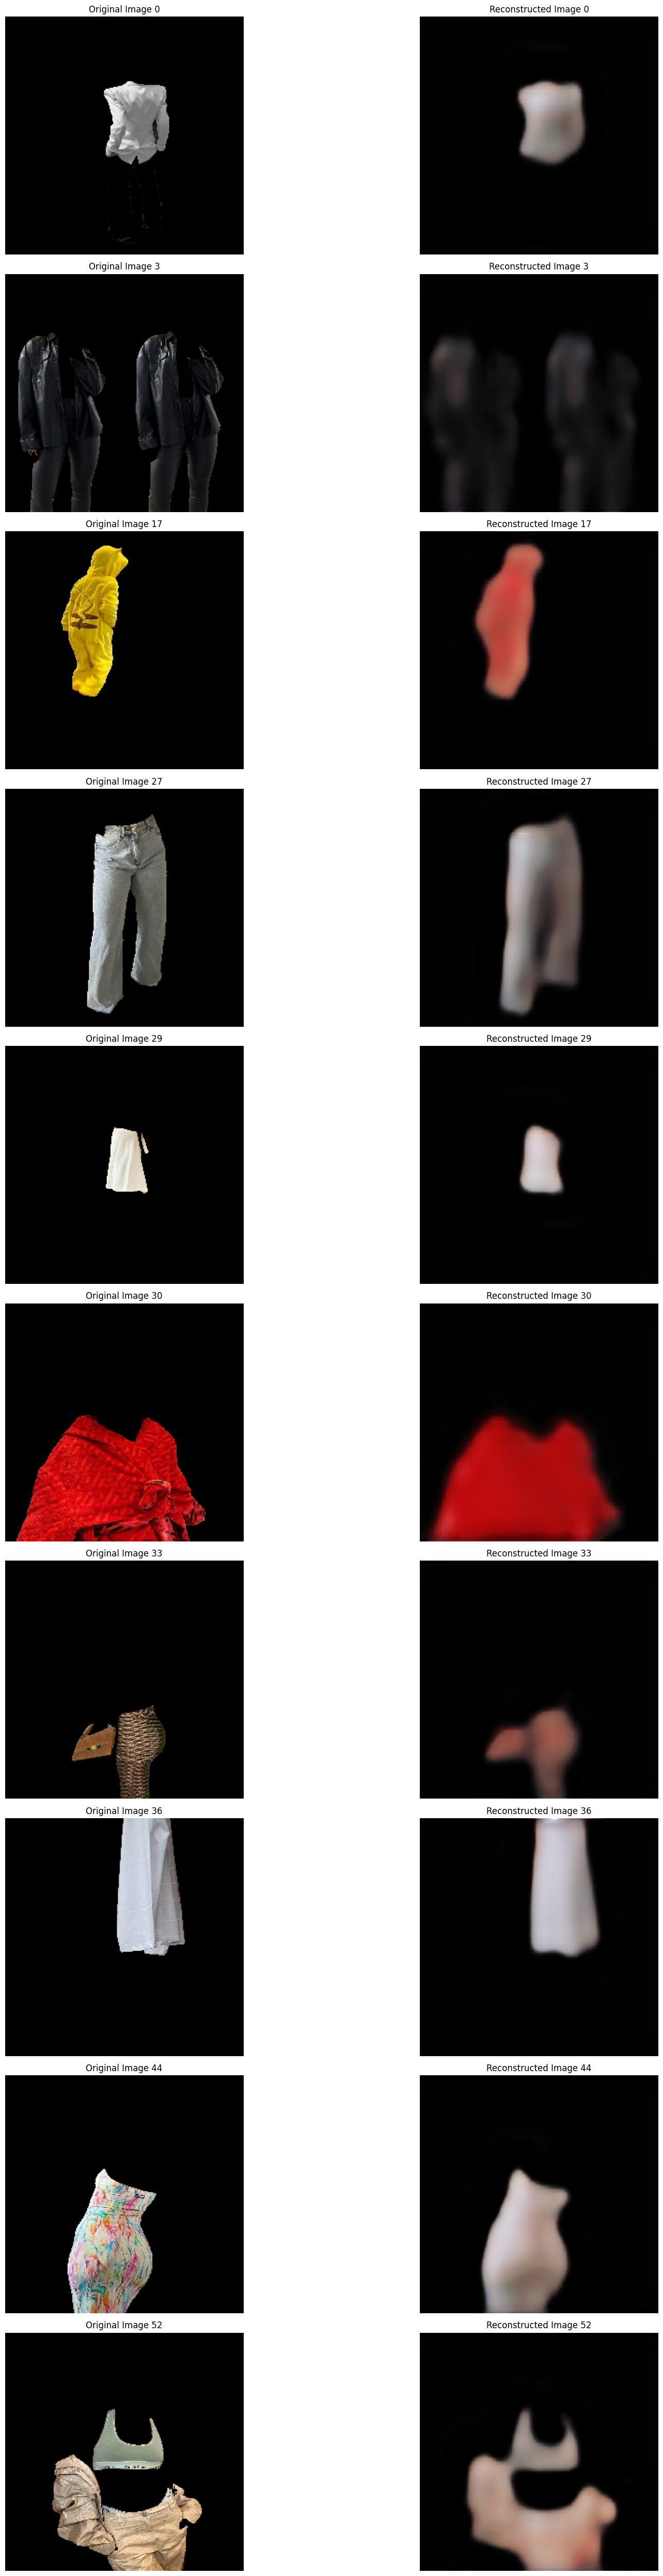

In [7]:
selected_indexes = [0, 3, 17, 27, 29, 30, 33, 36, 44, 52]  # List of selected indexes for displaying

fig, axs = plt.subplots(len(selected_indexes), 2, figsize=(20, 50))  # Adjust the figsize parameters to make images larger

for i, idx in enumerate(selected_indexes):
    img = image_list[idx]
    img = np.expand_dims(img, axis=0)  # Add the batch size dimension
    reconstructed_img = autoencoder.predict(img)

    # Reshape and rescale the images for display
    original_img = img.reshape((256, 256, 3))
    reconstructed_img = reconstructed_img.reshape((256, 256, 3))

    # Display original image
    axs[i, 0].imshow(original_img)
    axs[i, 0].set_title("Original Image {}".format(idx))
    axs[i, 0].axis('off')

    # Display reconstructed image
    axs[i, 1].imshow(reconstructed_img)
    axs[i, 1].set_title("Reconstructed Image {}".format(idx))
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


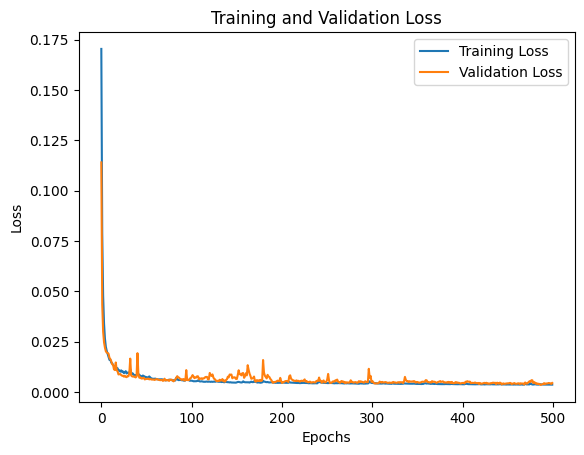

In [8]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
autoencoder.save('/content/drive/MyDrive/autoencoder_instagram/autoencoder.h5')